In [1]:
import numpy as np                        # Numpy for mathematical operations
import astropy.io.fits as fits            # Astropy for interpreting FITS files
import matplotlib.patches as patches      # Patches for clear figure labelling
import matplotlib.pyplot as plt           # Matplotlib for plot
import os                                 # OS for handling large amounts of files
import pandas                             # Pandas for clear file table
from astroquery.vizier import Vizier      # VizieR catalog query from Astroquery, more info:
                                          # https://astroquery.readthedocs.io/en/latest/

from astropy.coordinates import SkyCoord  # RA and Dec transformations
import astropy.units as u                 # Units for RA and Dec transformations

## Preparing and Reducing Data:

In [3]:
data_dir = './Lab3Files/'  # Location of FITS files
data_files = np.array(sorted(os.listdir(data_dir)))  # List of all files

In [4]:
os.chdir(data_dir)  # Working in location where files are located

In [5]:
fits_files = []

for i, val in enumerate(data_files):  # Specifying fits files in folder
    if val.endswith('.fits'):
        fits_files.append(val)
        
fits_files = np.array(fits_files)     # Converting to Numpy array for easier operations later

In [6]:
def load_headers_all_files(headers):
    """ Reads and returns multiple FITS headers from all files """
    
    final = []

    for i, val in enumerate(fits_files):
        hdr = fits.open(fits_files[i])   # Opening all data files
        file_header = []
        for j in headers:
            f = hdr[0].header[j]         # Finding all desired header values for individual files
            file_header.append(f)        # Appending each desired header for individual files
        final.append(file_header)        # Appending all header values for each file into one array

    final = np.array(final).T            # Taking transpose of array for proper shape in following step
    
    output = np.full([len(headers), len(fits_files)], final, dtype = object)  # Output with final array in shape
    
    return output

In [7]:
headers = ['OBSTYPE', 'OBJECT', 'EXPTIME', 'FILTNAM', 'COVER']
obstypes, objects, exptimes, filters, overscans = load_headers_all_files(headers) # Calling the defined function here
headers_lists = list(zip(obstypes, objects, exptimes, filters, overscans))
fits_dataframe1=pandas.DataFrame(headers_lists, columns=headers)
fits_dataframe1

,OBSTYPE,OBJECT,EXPTIME,FILTNAM,COVER
0,OBJECT,flat,25,V,32
1,OBJECT,bias,0,Open,32
2,OBJECT,7 Iris,1,R,32
3,OBJECT,7 Iris,1.5,R,32
4,OBJECT,7 Iris,1.5,R,32
5,OBJECT,7 Iris,1.5,R,32
6,OBJECT,7 Iris,1.5,R,32
7,OBJECT,7 Iris,1.5,R,32
8,OBJECT,7 Iris,1.5,V,32
9,OBJECT,7 Iris,2,V,32


In [8]:
bias = fits_files[objects == 'bias'][0]  # Bias frame from the device (taken with no filter)

def load_frame_overscan_remove_bias_subtract(filename):
    """ 
    ARGUMENTS:
    ================================================================
    filename - Name of any frame intended for reduction
    
    RETURNS:
    ================================================================
    Image data points with bias subtracted and overscan region removed
    """
    
    hdr = fits.open(filename)           # Opening desired file
    overscan = hdr[0].header['COVER']   # Obtaining length of overscan region
    
    image = fits.getdata(filename)      # Extracting data points from file
    image = image - fits.getdata(bias)  # Subtracting bias frame from science
    image = image[:,:-overscan]         # Removing overscan region from the end of data points
    
    return image

In [9]:
def plot_fits_im(ax, data, xlabel='pixels(x)', ylabel='pixels(y)', title='', **imshow_kwargs):
    """ Plots CCD image """
    ax.imshow(data, **imshow_kwargs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

In [10]:
flatV = fits_files[objects == 'flat'][0]   # V-band flat frame
flatR = fits_files[objects == 'flat'][-1]  # R-band flat frame

In [11]:
def load_reduced_science_frame(filename, flat):
    """
    Loads a Science frame specified by the FITS file name,
    performs reduction through bias subtraction and normalized
    flat field correction and returns the data
    
    ARGUMENTS:
    ================================================================
    filename - Name of science frame intended for reduction
    flat - Name of flat file using corresponding filter
    
    RETURNS:
    ================================================================
    Reduced science frame with bias subtracted, overscan removed, and flat normalization applied
    """
    
    sdata = load_frame_overscan_remove_bias_subtract(filename)
                        # Running science frame through previous function to bias subtract and remove overscan
    sdata[sdata >= 60000] = 1         # Removing hot pixels from science frame data
    fdata = load_frame_overscan_remove_bias_subtract(flat)
                        # Running flat frame through previous function to bias subtract and remove overscan
    fnorm = fdata / np.median(fdata)  # Normalization factor
    fnorm[fnorm == 0] = 1             # Removing values of 0 from normalization factor
    data = sdata / fnorm              # Final form of data after reduction
    
    return data

In [12]:
science_frame_1 = fits_files[objects == '7 Iris'][1]   # R-filter in first time period
science_frame_2 = fits_files[objects == '7 Iris'][8]   # V-filter in first time period
science_frame_3 = fits_files[objects == '7 Iris'][-2]  # R-filter in second time period

Text(0, 0.5, 'Pixels(y)')

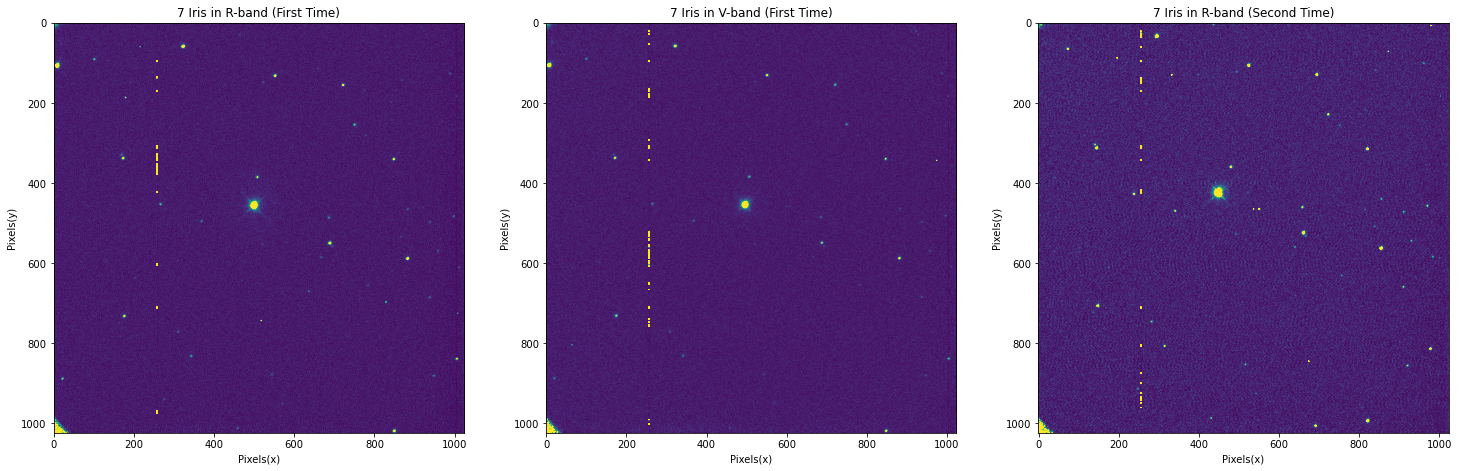

In [13]:
science_data_1 = load_reduced_science_frame(science_frame_1, flatR)  # Reduced data for each science frame
science_data_2 = load_reduced_science_frame(science_frame_2, flatV)
science_data_3 = load_reduced_science_frame(science_frame_3, flatR)

rows = 1
columns = 3
plt.figure(figsize=(25,10))  # Plot of each reduced science frame image

plt.subplot(rows, columns, 1)
plt.imshow(science_data_1, vmax = np.median(science_data_1) * 15, cmap = "viridis")
plt.title('7 Iris in R-band (First Time)')
plt.xlabel('Pixels(x)')
plt.ylabel('Pixels(y)')

plt.subplot(rows, columns, 2)
plt.imshow(science_data_2, vmax = np.median(science_data_2) * 15, cmap = "viridis")
plt.title('7 Iris in V-band (First Time)')
plt.xlabel('Pixels(x)')
plt.ylabel('Pixels(y)')

plt.subplot(rows, columns, 3)
plt.imshow(science_data_3, vmax = np.median(science_data_3) * 40, cmap = "viridis")
plt.title('7 Iris in R-band (Second Time)')
plt.xlabel('Pixels(x)')
plt.ylabel('Pixels(y)')

## Identifying stars:

In [14]:
def find_star_locs(im_data, n_size = 10, bright_count_thresh=10):
    """
    ARGUMENTS:
    ================================================================
    im_data - Reduced 2D FITS Data
    n_size  - Neighborhood size to consider for windowing (pixels)
    bright_count_thresh - Threshold for number of 'bright'pixels in
                          neighborhood to be considered a star.
    RETURNS:
    ================================================================
    x and y positions of stars in science frame
    """
    mew = np.mean(im_data)
    thresh = mew * 2.2           # Minimum threshold for intensitiy to be considered a star

    neighbors = [                # Region to check surrounding pixels for star intensity
        [-1, -1],
        [-1, 0],
        [-1, 1],
        [0, -1],
        [0, 1],
        [1, -1],
        [1, 0],
        [1, 1]
    ]

    num_rows, num_columns = im_data.shape         # Separating size of input data

    star_id = 1
    stars = np.zeros((num_rows, num_columns, 2))  # Empty array with 2 channels: threshold met and star identification
    
    star_pixels_dict = {}
    
    for i in range(num_rows - n_size):
        for j in range(num_columns - n_size):
            window = im_data[i:i+n_size, j:j+n_size]          # Input size of area to check for stars
            window_thresh = np.where(window >= thresh, 1, 0)
            num_brights = np.sum(window_thresh)
        
            if num_brights > bright_count_thresh:  # Regions with more star pixels than bright_count_thresh input
                x = i + n_size//2
                y = j + n_size//2
                stars[x, y, 0] = 1
                
    
    for i in range(num_rows):
        for j in range(num_columns):
            if stars[i, j, 0] == 0 or stars[i, j, 1] != 0: # If pixel is not in a star or is in previously seen star
                continue
                
            # Is a new star
            star_pixels = [[i, j]]
            stars[i, j, 1] = star_id
            star_pixels_dict[star_id] = []                 # Dictionary to refer to indices of stars
            
            while len(star_pixels) > 0:                    # While there are pixels in the star
                x, y = star_pixels.pop(0)
                star_pixels_dict[star_id].append([x, y])
                for n_x, n_y in neighbors:
                    n_x += x                               # Adding the neighboring pixels in stars
                    n_y += y
                
                    if stars[n_x, n_y, 0] == 1 and stars[n_x, n_y, 1] == 0:
                        # Add star to list of all stars
                        star_pixels.append([n_x, n_y])
                        stars[n_x, n_y, 1] = star_id
    
            star_id += 1  # Identifying stars by numbers starting with 1
            
    list_pos = []
    for star_id, star_pixels in star_pixels_dict.items():
        min_x = im_data.shape[0] + 100000           # Starting with a large number to later find minimum pixels
        max_x = -1
        min_y = im_data.shape[1] + 100000
        max_y = -1
        
        for x, y in star_pixels:
            min_x = min(min_x, x)
            max_x = max(max_x, x)
            min_y = min(min_y, y)
            max_y = max(max_y, y)
            
        center_x = (min_x + max_x) // 2
        center_y = (min_y + max_y) // 2
        list_pos.append([center_x, center_y])       # Appending integer values for center of stars
        
    star_centers = np.zeros(im_data.shape)          # Empty array to fill with center values
    for x, y in list_pos:
        padd = n_size // 2
        star_centers[x-padd:x+padd, y-padd:y+padd] = 1  # Appending star centers within input size
        
    return list_pos

In [15]:
# Running function above for each science frame to locate objects

ident_star_locs_1 = find_star_locs(science_data_1, bright_count_thresh=30)
ident_star_locs_2 = find_star_locs(science_data_2, bright_count_thresh=30)
ident_star_locs_3 = find_star_locs(science_data_3, bright_count_thresh=30)

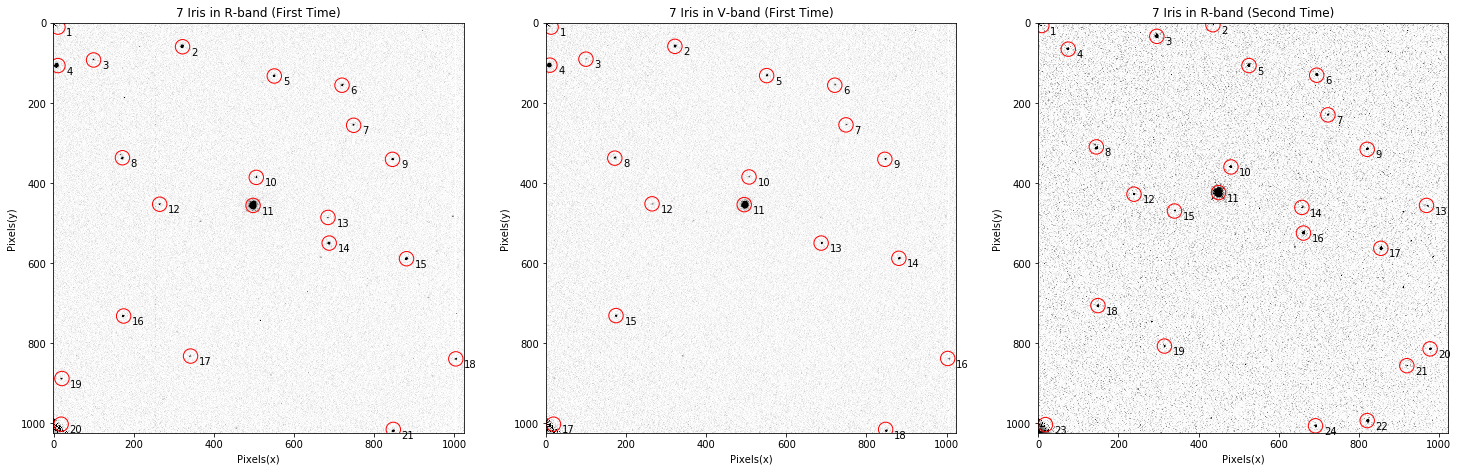

In [16]:
rows = 1
columns = 3
fig2 = plt.figure(figsize=(25,10))

ax1 = plt.subplot(rows, columns, 1)
plt.imshow(science_data_1, vmax = np.median(science_data_1) * 15, cmap = "Greys")
plt.title('7 Iris in R-band (First Time)')
plt.xlabel('Pixels(x)')
plt.ylabel('Pixels(y)')
for label, center in enumerate(ident_star_locs_1):
    label = label + 1
    x, y = center
    center = (y, x)  # Accounting for shape change in enumerate function
    r = 18           # Setting circle radius to 18 pixels for better visibility
    circle = plt.Circle(center, radius=r, facecolor='none', edgecolor='r')  # Circling stars
    ax1.add_patch(circle)
    t = plt.text(center[0] + r + 3, center[1] + r + 3, label, color='k')    # Labelling stars with indices


ax2 = plt.subplot(rows, columns, 2)
plt.imshow(science_data_2, vmax = np.median(science_data_2) * 15, cmap = "Greys")
plt.title('7 Iris in V-band (First Time)')
plt.xlabel('Pixels(x)')
plt.ylabel('Pixels(y)')
for label, center in enumerate(ident_star_locs_2):
    label = label + 1
    x, y = center
    center = (y, x)  # Accounting for shape change in enumerate function
    r = 18           # Setting circle radius to 18 pixels for better visibility
    circle = plt.Circle(center, radius=r, facecolor='none', edgecolor='r')  # Circling stars
    ax2.add_patch(circle)
    t = plt.text(center[0] + r + 3, center[1] + r + 3, label, color='k')    # Labelling stars with indices

                               
ax3 = plt.subplot(rows, columns, 3)
plt.imshow(science_data_3, vmax = np.median(science_data_3) * 40, cmap = "Greys")
plt.title('7 Iris in R-band (Second Time)')
plt.xlabel('Pixels(x)')
plt.ylabel('Pixels(y)')
for label, center in enumerate(ident_star_locs_3):
    label = label + 1
    x, y = center
    center = (y, x)  # Accounting for shape change in enumerate function
    r = 18           # Setting circle radius to 18 pixels for better visibility
    circle = plt.Circle(center, radius=r, facecolor='none', edgecolor='r')  # Circling stars
    ax3.add_patch(circle)
    t = plt.text(center[0] + r + 3, center[1] + r + 3, label, color='k')    # Labelling stars with indices
    
fig2.show()  # Images with stars identified

## Calculating Centroids:

In [17]:
# Position array that is same dimension as the science images, assuming they are all the same size
row_dim = np.shape(science_data_1)[0]
row_pos = np.array(range(row_dim))[np.newaxis]
pos_xarr = np.tile(row_pos.T, (1 ,row_dim))
pos_yarr = np.tile(row_pos  , (row_dim,1 ))
pos_arr = np.dstack((pos_xarr, pos_yarr))

$$ p_c = \frac{\sum_{i=1}^{N}p_i I_i}{\sum_{i=1}^{N}I_i} $$

$$ \sigma_{p_c}^2 = \frac{\sum_jI_j(p_j-p_c)^2}{(\sum_iI_i)^2} $$

where $ p_c $ is the pixel centroid value, $ p_i $ are pixel values in the peak, and $ I_i $ are corresponding intensity values.

In [18]:
def calc_centroids_2d(intarr, posarr, loc_list, window_max = 20):
    """
    Calculating centroid location for each star in frame according to equation above
    
    PARAMETERS:
    ==================================================================================
    intarr - array of intensity for each star
    posarr - 2d array with same dimensions as frame
    loc_list - array of star locations in frame
    window_max - Size of Window to consider to find max pos of each star (in pixels)
    
    RETURNS:
    ==================================================================================
    centroids - List of list of centroid coordinates and corresponding uncertainities
                Format: [[xc, yc, unc_xc, unc_yc]]
    """
    
    centroids = [] # Append Tuples (xc, yc, xc_err, yc_err) of centroid coordinates
    # No. of tuples should equal length of loc_list
    
    xc, yc, unc_xc, unc_yc = [], [], [], []
      
    for x, y in loc_list:                           # Windows around star center locations from previous function
        padd = window_max // 2
        posarr_x_window = pos_arr[x - padd:x + padd, y]
        posarr_y_window = pos_arr[x, y - padd:y + padd]
        intarr_x_window = intarr[x - padd:x + padd, y]
        intarr_y_window = intarr[x, y - padd:y + padd]

        posarr_x = [p[0] for p in posarr_x_window]  # Pixels positions in star windows
        posarr_y = [p[1] for p in posarr_y_window]

        numerator_x = 0
        denominator_x = 0
        snr_x = 0
        for i in range(len(posarr_x)):              # Centroids in x-direction
            numerator_x += posarr_x[i] * intarr_x_window[i]
            denominator_x += intarr_x_window[i]
            snr_x += np.sqrt(posarr_x[i] / window_max)
        print('SNR in x =', snr_x)              # Signal-to-noise ratio in x of asteroid
        
        if denominator_x != 0:
            xc = numerator_x/denominator_x
        else:
            xc = 1000  # Avoiding divide by zero by setting large number to replace those centroid values

        err_numerator_x = 0
        err_denominator_x = 0
        for i in range(len(posarr_x)):              # Centroid uncertainties in x-direction
            err_numerator_x += intarr_x_window[i] * (xc**2)
            err_denominator_x += (intarr_x_window[i])**2
            
        if denominator_x != 0:
            unc_xc = err_numerator_x/err_denominator_x
        else:
            unc_xc = 1000  # Avoiding divide by zero
            
        numerator_y = 0
        denominator_y = 0
        snr_y = 0
        for i in range(len(posarr_y)):              # Centroids in y-direction
            numerator_y += posarr_y[i] * intarr_y_window[i]
            denominator_y += intarr_y_window[i]
            snr_y += np.sqrt(posarr_y[i])
        print('SNR in y =', snr_y)              # Signal-to-noise ratio in x of asteroid
        
        if denominator_y != 0:
            yc = numerator_y/denominator_y
        else:
            yc = 1000     # Avoiding divide by zero
            
        err_numerator_y = 0
        err_denominator_y = 0
        for i in range(len(posarr_y)):              # Centroid uncertainties in y-direction
            err_numerator_y += intarr_y_window[i] * (yc**2)
            err_denominator_y += (intarr_y_window[i])**2
            
        if denominator_y != 0:
            unc_yc = err_numerator_y/err_denominator_y
        else:
            unc_yc = 1000  # Avoiding divide by zero
            
        centroids.append([xc, yc, unc_xc, unc_yc])  # Appending centroid values and uncertainties in x and y-direction
        
    return centroids

In [19]:
# Running function to calculate centroids and corresponding uncertainties for each science frame
centroids1 = calc_centroids_2d(science_data_1, pos_arr, ident_star_locs_1)
centroids2 = calc_centroids_2d(science_data_2, pos_arr, ident_star_locs_2)
centroids3 = calc_centroids_2d(science_data_3, pos_arr, ident_star_locs_3)

SNR in x = 13.788931828532839
SNR in y = 61.66597781141981
SNR in x = 34.455662400164016
SNR in y = 358.5939991076478
SNR in x = 42.99068746193321
SNR in y = 199.41546278836105
SNR in x = 46.13498325721726
SNR in y = 61.66597781141981
SNR in x = 51.465950849201064
SNR in y = 469.24829217184174
SNR in x = 55.757780934392486
SNR in y = 536.4656359799487
SNR in x = 71.47971145637587
SNR in y = 547.1705014443843
SNR in x = 82.03356551587265
SNR in y = 261.8789821912765
SNR in x = 82.51976537569156
SNR in y = 581.5462727286742
SNR in x = 87.80414963894496
SNR in y = 449.6592286695613
SNR in x = 95.44440783683824
SNR in y = 446.0866688611192
SNR in x = 95.12955674742135
SNR in y = 325.24979036718554
SNR in x = 98.53759457917991
SNR in y = 523.2543762530923
SNR in x = 104.8317577627695
SNR in y = 524.399812611406
SNR in x = 108.48832881288575
SNR in y = 593.4612233801264
SNR in x = 120.95359738444144
SNR in y = 264.16081310820056
SNR in x = 128.95658205513365
SNR in y = 369.5811983312945
SNR 

In [20]:
print('SNR of 7 Iris in first frame =', (95.44440783683824 + 446.0866688611192) / 2)

SNR of 7 Iris in first frame = 270.76553834897874


In [21]:
# Converting to Numpy arrays for easier operations
centroids1 = np.array(centroids1)
centroids2 = np.array(centroids2)
centroids3 = np.array(centroids3)

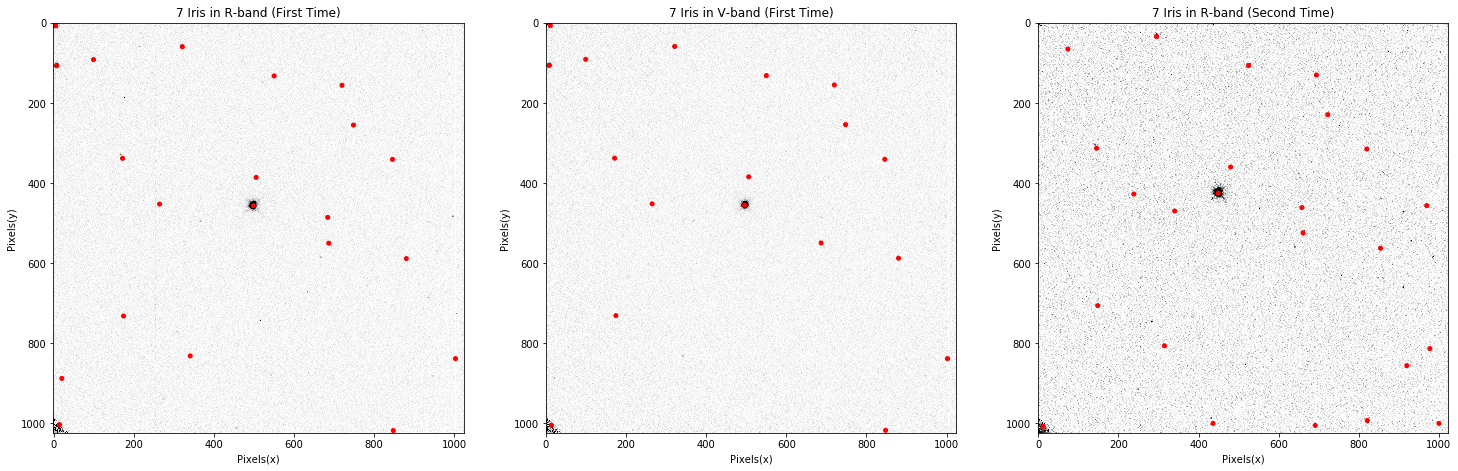

In [22]:
rows = 1
columns = 3
fig3 = plt.figure(figsize=(25,10))

ax1 = plt.subplot(rows, columns, 1)
plt.imshow(science_data_1, vmax = np.median(science_data_1) * 15, cmap = "Greys")
plt.title('7 Iris in R-band (First Time)')
plt.xlabel('Pixels(x)')
plt.ylabel('Pixels(y)')
for i, center in enumerate(centroids1):
    x, y = center[0], center[1]
    center = (y, x)
    r = 5
    circle = plt.Circle(center, radius=r, color='r')  # Plotting centroid points over stars in science frame
    ax1.add_patch(circle)

ax2 = plt.subplot(rows, columns, 2)
plt.imshow(science_data_2, vmax = np.median(science_data_2) * 15, cmap = "Greys")
plt.title('7 Iris in V-band (First Time)')
plt.xlabel('Pixels(x)')
plt.ylabel('Pixels(y)')
for i, center in enumerate(centroids2):
    x, y = center[0], center[1]
    center = (y, x)
    r = 5
    circle = plt.Circle(center, radius=r, color='r')  # Plotting centroid points over stars in science frame
    ax2.add_patch(circle)
                               
ax3 = plt.subplot(rows, columns, 3)
plt.imshow(science_data_3, vmax = np.median(science_data_3) * 40, cmap = "Greys")
plt.title('7 Iris in R-band (Second Time)')
plt.xlabel('Pixels(x)')
plt.ylabel('Pixels(y)')
for i, center in enumerate(centroids3):
    x, y = center[0], center[1]
    center = (y, x)
    r = 5
    circle = plt.Circle(center, radius=r, color='r')  # Plotting centroid points over stars in science frame
    ax3.add_patch(circle)
    
fig3.show()  # Images with centroids identified

## Finding Star Positions:

In [23]:
ra_center = '07:10:57.8'     # RA and Dec entered into telescope guidance
dec_center = '+16:07:59'
# Stanadard coordinate object for easier conversions and querying
center_coord = SkyCoord(ra = ra_center, dec = dec_center, unit = (u.hour, u.deg), frame='icrs')

In [24]:
magnitude_limit = 15.5  # Chosen magnitude limit to match number of centroids in R-band list (20)

vizier = Vizier(column_filters = {"R2mag" : "<{}".format(magnitude_limit)})  # VizieR object

vizier.ROW_LIMIT = -1  # Show every star from VizieR

fov_width = '6.3m'  # Size of region visible to telescope used to collect frames in arcminutes
fov_height = '6.3m'

# Table of VizieR data using USNO-B1 catalog
result_table = vizier.query_region(center_coord, width = fov_width, height = fov_height, catalog = "USNO-B1")

print ("Total number of objects retrieved:", len(result_table[0]))
print ("Column names:", result_table[0].keys())

Total number of objects retrieved: 21
Column names: ['USNO-B1.0', 'RAJ2000', 'DEJ2000', 'e_RAJ2000', 'e_DEJ2000', 'Epoch', 'pmRA', 'pmDE', 'Ndet', 'B1mag', 'R1mag', 'B2mag', 'R2mag', 'Imag']


In [25]:
# Conversion functions from degrees to radians for sine and cosine for easier implementation later on
def sin(t):
    return np.sin((t*np.pi)/180)
def cos(t):
    return np.cos((t*np.pi)/180)

Text(0, 0.5, 'Declination in degrees')

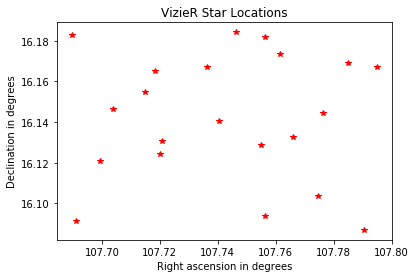

In [26]:
# Extract required data from obtained query results
ra_cat     = np.array(result_table[0]["RAJ2000"])
dec_cat    = np.array(result_table[0]["DEJ2000"])
pm_ra      = np.array(result_table[0]["pmRA"])
pm_dec     = np.array(result_table[0]["pmDE"])
mag        = np.array(result_table[0]["R2mag"])

# Convert result into form we want

epoch = 2022.0   # Conversion factor from epoch J2000 since the science image was taken in 2022


pm_ra  = pm_ra / 1000.0 / 3600.0 / cos(dec_cat)  # RA conversion to degrees/year
pm_dec = pm_dec / 1000.0 / 3600.0  # Dec conversion to degrees/year

# Move the stars
ra_cat  += (epoch - 2000.0) * pm_ra
dec_cat += (epoch - 2000.0) * pm_dec

# TODO: Needs labels!
plt.plot(ra_cat, dec_cat, 'r*')
plt.title('VizieR Star Locations')
plt.xlabel('Right ascension in degrees')
plt.ylabel('Declination in degrees')

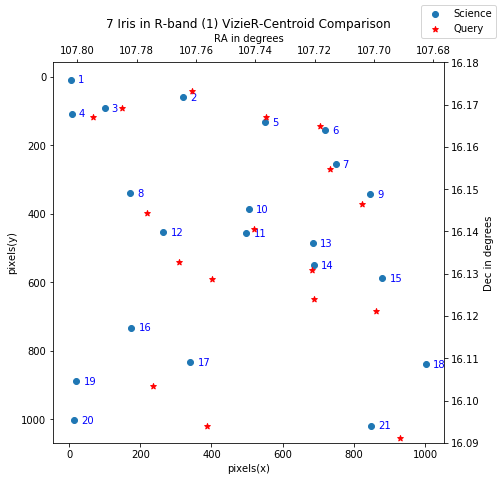

In [27]:
fig4 = plt.figure(figsize = [7,7])
ax4 = fig4.add_subplot(111, frame_on=True)
axq4 = fig4.add_subplot(111, frame_on=False)

science4 = ax4.scatter(np.squeeze(centroids1[:,1]), np.squeeze(centroids1[:,0]))  # Centroid points
query4 = axq4.scatter(ra_cat, dec_cat, color='red', marker='*')  # USNO-B1 Points

ax4.set_ylim(ax4.get_ylim()[::-1])  # Reversing y-axis of CCD

for i, (loc_y, loc_x) in enumerate(centroids1[:,0:2]):  # Centroid labels
    ax4.text(loc_x+20, loc_y+10, str(i+1), color = 'blue')
    
axq4.xaxis.tick_top()
axq4.xaxis.set_label_position('top')
axq4.yaxis.tick_right()
axq4.yaxis.set_label_position('right')
axq4.set_xlim(axq4.get_xlim()[::-1])
axq4.set_ylim(16.09, 16.18)
    
ax4.set_xlabel('pixels(x)')
ax4.set_ylabel('pixels(y)')
axq4.set_xlabel('RA in degrees')
axq4.set_ylabel('Dec in degrees')
plt.title('7 Iris in R-band (1) VizieR-Centroid Comparison')
fig4.legend(['Science', 'Query'], loc=1)    # Legend placed above plot in upper right for better visibility
fig4.show()  # Plots first science frame centroids with VizieR star locations

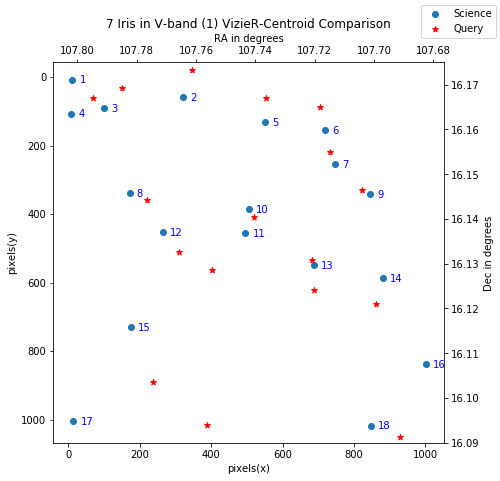

In [28]:
fig5 = plt.figure(figsize = [7,7])
ax5 = fig5.add_subplot(111, frame_on=True)
axq5 = fig5.add_subplot(111, frame_on=False)

science5 = ax5.scatter(np.squeeze(centroids2[:,1]), np.squeeze(centroids2[:,0]))  # Centroid points
query5 = axq5.scatter(ra_cat, dec_cat, color='red', marker='*')  # USNO-B1 points

ax5.set_ylim(ax5.get_ylim()[::-1])  # Reversing y-axis of CCD

for i, (loc_y, loc_x) in enumerate(centroids2[:,0:2]):  # Centroid labels
    ax5.text(loc_x+20, loc_y+10, str(i+1), color = 'blue')
    
axq5.xaxis.tick_top()
axq5.xaxis.set_label_position('top')
axq5.yaxis.tick_right()
axq5.yaxis.set_label_position('right')
axq5.set_xlim(axq5.get_xlim()[::-1])
axq5.set_ylim(16.09, 16.175)
    
ax5.set_xlabel('pixels(x)')
ax5.set_ylabel('pixels(y)')
axq5.set_xlabel('RA in degrees')
axq5.set_ylabel('Dec in degrees')
plt.title('7 Iris in V-band (1) VizieR-Centroid Comparison')
fig5.legend(['Science', 'Query'], loc=1)    # Legend placed above plot in upper right for better visibility
fig5.show()  # Plots second science frame centroids with VizieR star locations

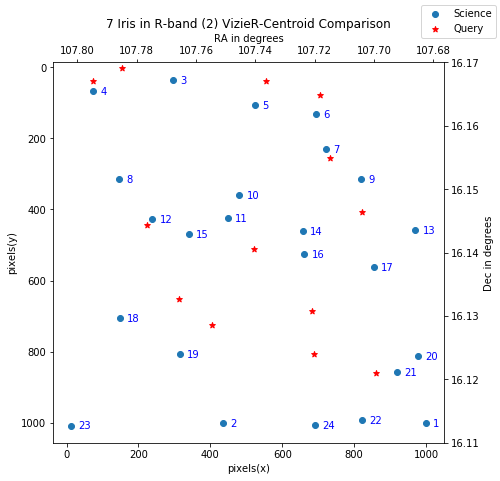

In [29]:
fig6 = plt.figure(figsize = [7,7])
ax6 = fig6.add_subplot(111, frame_on=True)
axq6 = fig6.add_subplot(111, frame_on=False)

science6 = ax6.scatter(np.squeeze(centroids3[:,1]), np.squeeze(centroids3[:,0]))  # Centroid points
query6 = axq6.scatter(ra_cat, dec_cat, color='red', marker='*')  # USNO-B1 Points

ax6.set_ylim(ax6.get_ylim()[::-1])  # Reversing y-axis of CCD

for i, (loc_y, loc_x) in enumerate(centroids3[:,0:2]):  # Centroid labels
    ax6.text(loc_x+20, loc_y+10, str(i+1), color = 'blue')
    
axq6.xaxis.tick_top()
axq6.xaxis.set_label_position('top')
axq6.yaxis.tick_right()
axq6.yaxis.set_label_position('right')
axq6.set_xlim(axq6.get_xlim()[::-1])
axq6.set_ylim(16.11, 16.17)
    
ax6.set_xlabel('pixels(x)')
ax6.set_ylabel('pixels(y)')
axq6.set_xlabel('RA in degrees')
axq6.set_ylabel('Dec in degrees')
plt.title('7 Iris in R-band (2) VizieR-Centroid Comparison')
fig6.legend(['Science', 'Query'], loc=1)    # Legend placed above plot in upper right for better visibility
fig6.show()  # Plots second science frame centroids with VizieR star locations

## Ideal Coordinate Conversion:

In [30]:
skyra = np.full(len(ra_cat), center_coord.ra.deg)     # Array of input values for RA using SkyCoord
skydec = np.full(len(dec_cat), center_coord.dec.deg)  # Array of input values for Dec using SkyCoord

In [31]:
# RA and Dec to Cartesian for Vizier objects using SkyCoord output as reference according to formula below
d = cos(skydec) * cos(dec_cat) * cos(ra_cat - skyra) + sin(skydec) * sin(dec_cat)
X = - cos(dec_cat) * sin(ra_cat - skyra) / d
Y = - (sin(skydec) * cos(dec_cat) * cos(ra_cat - skyra) - cos(skydec) * sin(dec_cat)) / d

$$ X = -\frac{cos(\delta)sin(\alpha - \alpha_0)}{cos(\delta_0)cos(\delta)cos(\alpha - \alpha_0)+sin(\delta)sin(\delta_0)} $$

$$ Y = -\frac{sin(\delta_0)cos(\delta)cos(\alpha - \alpha_0)-cos(\delta_0)sin(\delta)}{cos(\delta_0)cos(\delta)cos(\alpha - \alpha_0)+sin(\delta)sin(\delta_0)} $$

where $X$ and $Y$ are rectangular coordinates, $\alpha_0$ and $\delta_0$ are expected RA and Dec from SkyCoord, and $\alpha$ and $\delta$ are RA and Dec from VizieR

In [166]:
f = 16480       # Focal length in mm
p = 0.015 * 2   # CCD pixel size in mm, doubled to account for binning

# Cartesian coordinate output for VizieR objects according to formula below
# (Assumes ideal camera and same size for each of the three science frames)
x = f * (X / p) + (np.shape(science_data_1)[0] / 2)
y = f * (Y / p) + (np.shape(science_data_1)[1] / 2)

$$ x = f*\frac{X}{p} + x_0 $$

$$ y = f*\frac{Y}{p} + y_0 $$

where $x$ and $y$ are ideal coordinates, $X$ and $Y$ are previously defined converted coordinates, and $x_0$ and $y_0$ are the central pixel of the CCD

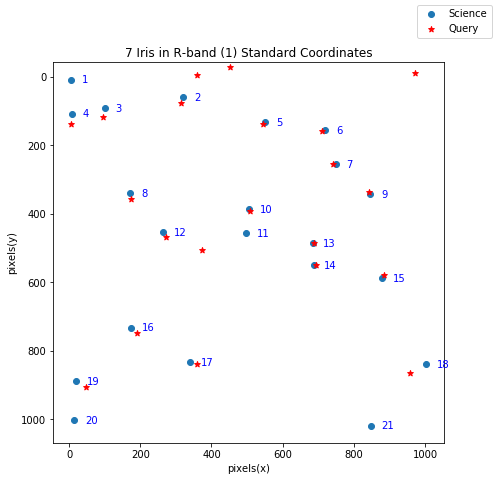

In [395]:
fig7 = plt.figure(figsize = [7,7])
ax7 = fig7.add_subplot(111, frame_on=True)
axq7 = fig7.add_subplot(111, frame_on=False)

for i, (loc_y, loc_x) in enumerate(centroids1[:,0:2]):
    ax7.text(loc_x+30, loc_y+10, str(i+1), color = 'blue')
    
ax7.scatter(np.squeeze(centroids1[:,1]), np.squeeze(centroids1[:,0]))
ax7.set_ylim(ax7.get_ylim()[::-1])  # Flip y-axis
ax7.set_xlabel('pixels(x)')
ax7.set_ylabel('pixels(y)')
axq7.set_xticks([])       # Removing overlapping axis ticks
axq7.set_yticks([])

x1id = x - 10  # Translational shift in x-direction
y1id = -y
y1id += 975    # Inversion and translational shift in y-direction

axq7.scatter(x1id, y1id, color='red', marker='*')
axq7.set_xlim(ax7.get_xlim())  # Matching axes limits
axq7.set_ylim(ax7.get_ylim())

plt.title('7 Iris in R-band (1) Standard Coordinates')
fig7.legend(['Science', 'Query'], loc=1)    # Legend placed above plot in upper right for better visibility

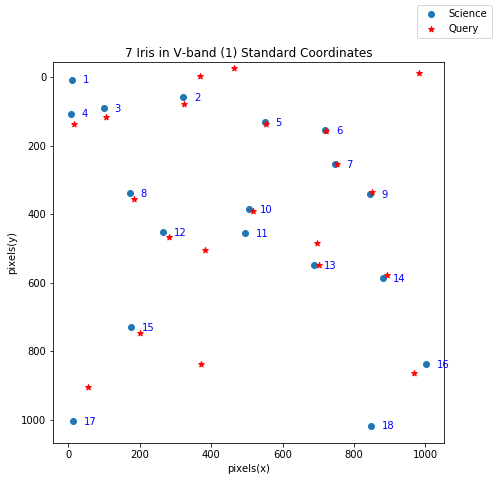

In [396]:
fig8 = plt.figure(figsize = [7,7])
ax8 = fig8.add_subplot(111, frame_on=True)
axq8 = fig8.add_subplot(111, frame_on=False)

for i, (loc_y, loc_x) in enumerate(centroids2[:,0:2]):
    ax8.text(loc_x+30, loc_y+10, str(i+1), color = 'blue')
    
ax8.scatter(np.squeeze(centroids2[:,1]), np.squeeze(centroids2[:,0]))  # Manual translational shift
ax8.set_ylim(ax8.get_ylim()[::-1])  # Flip y-axis
ax8.set_xlabel('pixels(x)')
ax8.set_ylabel('pixels(y)')

x2id = x
y2id = -y
y2id += 975  # Inversion and translational shift of y-axis

axq8.scatter(x2id, y2id, color='red', marker='*')
axq8.set_xlim(ax8.get_xlim())  # Matching axes limits
axq8.set_ylim(ax8.get_ylim())
axq8.set_xticks([])       # Removing overlapping axis ticks
axq8.set_yticks([])

plt.title('7 Iris in V-band (1) Standard Coordinates')
fig8.legend(['Science', 'Query'], loc=1)    # Legend placed above plot in upper right for better visibility

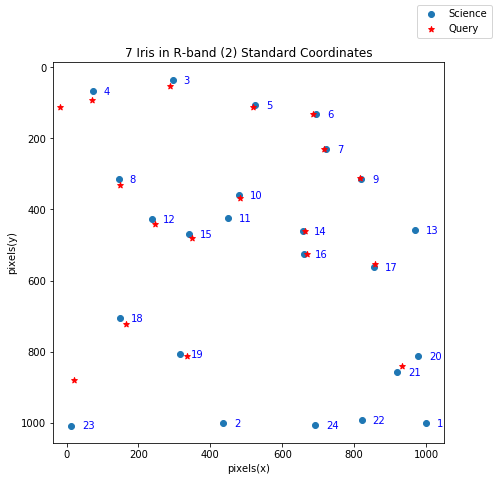

In [397]:
fig9 = plt.figure(figsize = [7,7])
ax9 = fig9.add_subplot(111, frame_on=True)
axq9 = fig9.add_subplot(111, frame_on=False)

for i, (loc_y, loc_x) in enumerate(centroids3[:,0:2]):
    ax9.text(loc_x+30, loc_y+10, str(i+1), color = 'blue')
    
ax9.scatter(np.squeeze(centroids3[:,1]), np.squeeze(centroids3[:,0]))  # Manual translational shift
ax9.set_ylim(ax9.get_ylim()[::-1])  # Flip y-axis
ax9.set_xlabel('pixels(x)')
ax9.set_ylabel('pixels(y)')

x3id = x - 35  # Translational shift in x-direction
y3id = -y
y3id += 950  # Inversion and translational shift in y-direction

axq9.scatter(x3id, y3id, color='red', marker='*')
axq9.set_xlim(ax9.get_xlim())  # Matching axes limits
axq9.set_ylim(ax9.get_ylim())
axq9.set_xticks([])       # Removing overlapping axis ticks
axq9.set_yticks([])

plt.title('7 Iris in R-band (2) Standard Coordinates')
fig9.legend(['Science', 'Query'], loc=1)    # Legend placed above plot in upper right for better visibility

## General Least Square Fit:

$$ \bar{T} = \begin{pmatrix} \frac{f}{p}a_{11} & \frac{f}{p}a_{12} & x_0 \\ \frac{f}{p}a_{21} & \frac{f}{p}a_{22} & y_0 \\ 0 & 0 & 1\end{pmatrix} $$

where $a_{11}$, $a_{12}$, $a_{21}$, and $a_{22}$ are plate constants and $x_0$ and $y_0$ are translations according to reference frame and

$$ \bar{X} = (\bar{T}^T\bar{T})^{-1}*\bar{T}^T*\bar{x} $$

where $\bar{X}$ are USNO locations and $\bar{x}$ are centroid locations with superscript T indicating the transpose and superscript -1 indicating the inverse.

In [308]:
x1_cent = []
y1_cent = []
X1_usno = []
Y1_usno = []
x1c = centroids1[:,0]
y1c = centroids1[:,1]

for i, val in enumerate(x1c):  # Matching up centroid values with corresponding ideal USNO objects for first frame
    dist = np.sqrt((x1c[i] - x1id)**2 + (y1c[i] - y1id)**2)
    mind = np.min(dist)   # Minimizing distance between points
    if mind > 30:         # Within threshold of 30 pixels to match up only the 10 best points
        continue
    x1_cent.append(x1c[i])  # Final centroid values
    y1_cent.append(y1c[i])
    X1_usno.append(x1id[dist == mind])  # Final USNO values
    Y1_usno.append(y1id[dist == mind])

In [309]:
# Converting to numpy arrays for easier operations
x1_cent = np.array(x1_cent)
y1_cent = np.array(y1_cent)
X1_usno = np.array(X1_usno)
Y1_usno = np.array(Y1_usno)

In [322]:
# Calculating plate constants for the device using VizieR and first frame coordinates according to equations below
# in order to later build the matrix above for the general least squares fit of the asteroid location

a_x1 = np.transpose(np.matrix(x1_cent))  # Matrix of x-values of centroids
B_x1 = np.transpose(np.matrix([(X1_usno).T[0], (Y1_usno).T[0], (np.full(len(x1_cent), 1))]))  # USNO matrix
                                # (f/p factor already absorbed into X1_usno and Y1_usno)
B_x1t = np.transpose(B_x1)      # Transpose of USNO matrix
BTB_x1 = B_x1t * B_x1           # Transpose times original USNO matrix
x1_inv = np.linalg.inv(BTB_x1)  # Inverse of BTB_x1
x1 = (x1_inv * B_x1t * a_x1).T  # Final plate constants [a_11 a_12 x_0]
x1 = np.array(x1)

a_y1 = np.transpose(np.matrix(y1_cent))  # Matrix of x-values of centroids
B_y1 = np.transpose(np.matrix([(X1_usno).T[0], (Y1_usno).T[0], (np.full(len(y1_cent), 1))]))  # USNO matrix
B_y1t = np.transpose(B_y1)      # Transpose of USNO matrix
BTB_y1 = B_y1t * B_y1           # Transpose times original USNO matrix
y1_inv = np.linalg.inv(BTB_y1)  # Inverse of BTB_y1
y1 = (y1_inv * B_y1t * a_y1).T  # Final plate constants [a_21 a_22 y_0]
y1 = np.array(y1)

T1 = np.matrix([x1[0], y1[0], np.array([0,0,1])])  # Final transformation matrix

$$ \begin{pmatrix} x_1 \\ x_2 \\ ... \\ x_N \end{pmatrix} = \begin{pmatrix} \frac{f}{p}X_1 & \frac{f}{p}Y_1 & 1 \\ \frac{f}{p}X_2 & \frac{f}{p}Y_2 & 1  \\ ... & ... & ... \\ \frac{f}{p}X_N & \frac{f}{p}Y_N & 1  \end{pmatrix} \begin{pmatrix} a_{11} & a_{12} & x_0 \end{pmatrix}$$

$$ \begin{pmatrix} y_1 \\ y_2 \\ ... \\ y_N \end{pmatrix} = \begin{pmatrix} \frac{f}{p}X_1 & \frac{f}{p}Y_1 & 1 \\ \frac{f}{p}X_2 & \frac{f}{p}Y_2 & 1  \\ ... & ... & ... \\ \frac{f}{p}X_N & \frac{f}{p}Y_N & 1  \end{pmatrix} \begin{pmatrix} a_{21} & a_{22} & y_0 \end{pmatrix}$$

where $x_N$ and $y_N$ are centroid locations and $X_N$ and $Y_N$ are previously calculated USNO-B1.0 star locations.

In [323]:
print(T1)  # Printing transformation matrix to ensure it looks correct

[[  1.00720028  -0.0307498    8.81269457]
 [  0.03409777   1.01528025 -19.26566675]
 [  0.           0.           1.        ]]


In [315]:
vec1 = np.transpose(np.matrix((x1c, y1c, 1)))  # Vector of all centroid values
aff1 = np.array(T1 * vec1)  # Applying matrix to vector according to equation below

$$ \begin{pmatrix} X & Y & 1 \end{pmatrix} = T^{-1} \begin{pmatrix} x & y & 1 \end{pmatrix} $$

where $X$ and $Y$ are sky positions of the asteroid, $T^{-1}$ is inverse of transformation matrix, and $x$ and $y$ are centroid position of asteroid

In [316]:
X1, Y1 = aff1[0:2,0]  # Standard coordinates of first frame

In [42]:
# Repeating the process above for the second time frame in the R-band

x3_cent = []
y3_cent = []
X3_usno = []
Y3_usno = []
x3c = centroids3[:,0]
y3c = centroids3[:,1]

for i, val in enumerate(x3c):  # Matching up centroid values with corresponding USNO objects for third frame
    dist = np.sqrt((x3c[i] - x3id)**2 + (y3c[i] - y3id)**2)
    mind = np.min(dist)   # Minimizing distance between points
    if mind > 27:         # Within threshold of 27 pixels to again match up 10 best points
        continue
    x3_cent.append(x3c[i])  # Final centroid values
    y3_cent.append(y3c[i])
    X3_usno.append(x3id[dist == mind])  # Final USNO values
    Y3_usno.append(y3id[dist == mind])

In [43]:
# Converting to numpy arrays for easier operations later
x3_cent = np.array(x3_cent)
y3_cent = np.array(y3_cent)
X3_usno = np.array(X3_usno)
Y3_usno = np.array(Y3_usno)

In [44]:
vec3 = np.transpose(np.matrix((x3c, y3c, 1)))  # Vector of centroid values
aff3 = np.array(T1 * vec3)  # The same transformation is still applicable

In [102]:
X3, Y3 = aff3[0:2,0]  # Standard coordinates of final frame

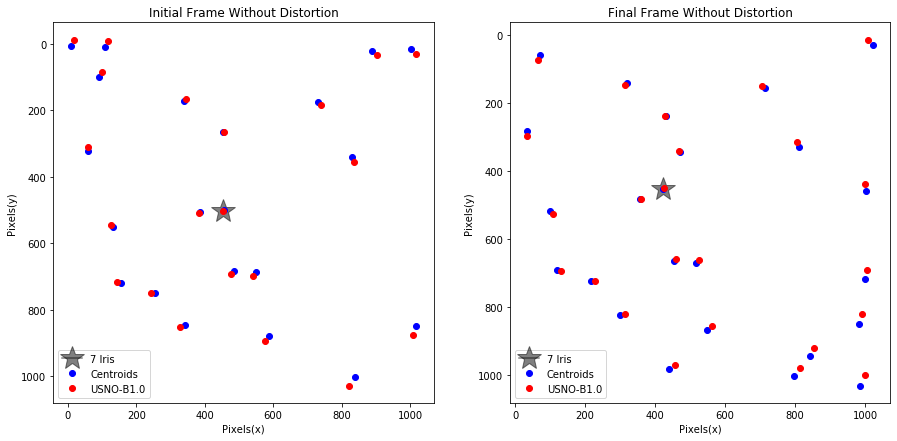

In [103]:
rows = 1
columns = 2
fig10 = plt.figure(figsize=(15,7))
X1ast = X1[10]
Y1ast = Y1[10]
X3ast = X3[10]
Y3ast = Y3[10]

ax10_1 = plt.subplot(rows, columns, 1)
plt.plot(X1ast, Y1ast, color='black', marker='*', alpha = 0.5, markersize=25, label='7 Iris')
plt.plot(x1c, y1c, 'bo', label='Centroids')
plt.plot(X1, Y1, 'ro', label='USNO-B1.0')
plt.xlabel('Pixels(x)')
plt.ylabel('Pixels(y)')
plt.title('Initial Frame Without Distortion')
plt.ylim(plt.ylim()[::-1])
plt.legend()

ax10_2 = plt.subplot(rows, columns, 2)
plt.plot(X3ast, Y3ast, color='black', marker='*', alpha = 0.5, markersize=25, label='7 Iris')
plt.plot(X3, Y3, 'bo', label='Centroids')
plt.plot(x3c, y3c, 'ro', label='USNO-B1.0')
plt.xlabel('Pixels(x)')
plt.ylabel('Pixels(y)')
plt.title('Final Frame Without Distortion')
plt.ylim(plt.ylim()[::-1])
plt.legend()

fig10.show()  # Plot of all centroid values, equivalent catalog points, and 7 Iris identified

In [324]:
errx1 = np.abs(x1c[10]-X1ast)
erry1 = np.abs(y1c[10]-Y1ast)
errx3 = np.abs(x3c[10]-X3ast)
erry3 = np.abs(y3c[10]-Y3ast)

print('Error in first time frame x =', errx1)
print('Error in first time frame y =', erry1)
print('')
print('Error in second time frame x =', errx3)
print('Error in second time frame y =', erry3)

Error in first time frame x = 3.2198557395838634
Error in first time frame y = 3.9223983830271436

Error in second time frame x = 1.9357706405887711
Error in second time frame y = 2.09854897453323


## Proper motion of 7 Iris:

$$ tan(\alpha - \alpha _{0}) = - \frac{X}{cos(\delta_0)-Ysin(\delta_0)} $$

$$ sin(\delta) = \frac{sin(\delta_0)+Ycos(\delta_0)}{\sqrt{1+X^2+Y^2}} $$

where $\alpha$ and $\delta$ are the desired RA and Dec of 7 Iris, $X$ and $Y$ are rectangular coordinates from above, and $\alpha_0$ and $\delta_0$ are RA and Dec from SkyCoord

In [370]:
def arctan(t):
    return np.arctan((t*np.pi)/180)
def arcsin(t):
    return np.arcsin((t*np.pi)/180)

In [389]:
# Rearranged equations above to calculate first and final RA and Dec of 7 Iris

RA1 = arctan(-X1ast / (cos(skydec[0])-(Y1ast*sin(skydec[0])))) + skyra[0]
Dec1 = arcsin((sin(skydec[0])+(Y1ast*cos(skydec[0]))) / np.sqrt(1+(X1ast**2)+(Y1ast**2))) + skydec[0]

RA3 = arctan(-X3ast / (cos(skydec[0])-(Y3ast*sin(skydec[0])))) + skyra[0]
Dec3 = arcsin((sin(skydec[0])+(Y3ast*cos(skydec[0]))) / np.sqrt(1+(X3ast**2)+(Y3ast**2))) + skydec[0]

t1 = 3.7053  # Exact time  of frames from log sheet in UTC hours
t3 = 5.0947

Text(0, 0.5, 'Declination (degrees)')

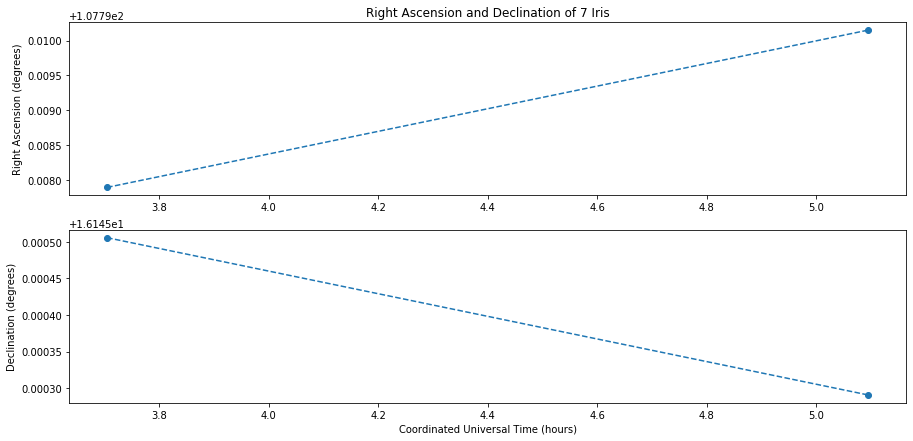

In [393]:
rows = 2
columns = 1
plt.figure(figsize = (15, 7))

plt.subplot(rows, columns, 1)
plt.plot([t1, t3], [RA1, RA3], 'o--')    # Right ascension vs. time
plt.title('Right Ascension and Declination of 7 Iris')
plt.ylabel('Right Ascension (degrees)')

plt.subplot(rows, columns, 2)
plt.plot([t1, t3], [Dec1, Dec3], 'o--')  # Declination vs. time
plt.xlabel('Coordinated Universal Time (hours)')
plt.ylabel('Declination (degrees)')

In [394]:
mRA = (RA3 - RA1) / (t3 - t1)
print('Change in RA =', mRA, 'degrees')

mDec = (Dec3 -Dec1) / (t3 - t1)
print('Change in Dec =', mDec, 'degrees')

Change in RA = 0.0016247801014783285 degrees
Change in Dec = -0.00015469932785417697 degrees


Text(0, 0.5, 'Pixels(y)')

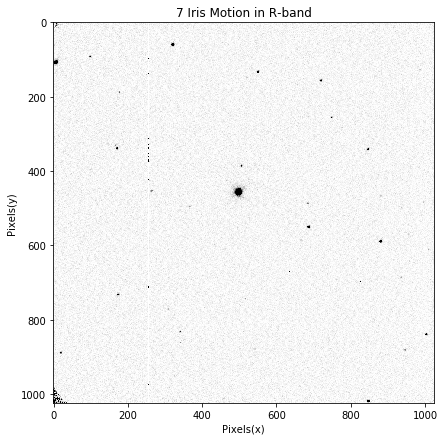

In [78]:
plt.figure(figsize = [7,7])
plt.imshow(science_data_1, vmax = np.median(science_data_1) * 15, cmap = "Greys")
plt.title('7 Iris Motion in R-band')
plt.xlabel('Pixels(x)')
plt.ylabel('Pixels(y)') # Plotting the first science frame again for Figure 8 in report